# Mineração Estatística de Dados 2019
    Nome: Ricardo França Fernandes do Vale       Número USP: 9293477
    Nome: André Alves Ambrósio                   Número USP: 9762852

##  Projeto	3:	Seleção	e transformação	de	atributos, avaliação de classificadores

Este trabalho possui como objetivo utilizar métodos e métricas diferentes para definir quais modelos de classificação possuem resultados melhores em determinada situação.

Neste trabalho serão apresentados os seguintes modelos:
- Redes Neurais
- Random Forest
- Naive Bayes
- KNN

As seguintes métricas:
- Acurácia
- Precisão
- Recuperação
- F1 (Ponderamento entre Precisão e Recuperação)
- Curva ROC

E utilizando os seguintes métodos:
- K-fold cross validation
- K-fold cross validation estratificado

In [108]:
# Neste bloco sao listados todos os imports usados no projeto
import random
random.seed(1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skdata
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

## Utilizando diferentes métricas para selecionar o melhor modelo de classificação

A seguir, iremos comparar quatro modelos de classificação com algoritmos e pressupostos (quando existem) bem distintos. E para quantificar o quão bom tal modelo é em relação aos demais, iremos utilizar quatro métricas distintas.

Os modelos a serem testados serão: modelos de classificação Redes Neurais, Naive Bayes, KNN e Random Forest.

As métricas a serem utilizadas serão: Acurácia, Precision, Recall e F1.

Para isso, iremos gerar dados aleatoriamente com categoria binária e então tentar classificar as observações.

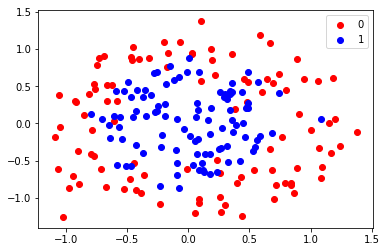

In [2]:
# Gerando a base de dados
n_samples = 200
X, Y = skdata.make_circles(n_samples=n_samples, factor=0.5, noise=0.2)

d = np.column_stack((X,np.transpose(Y)))
data = DataFrame(data = d, columns=['X1', 'X2', 'y'])
features_names = ['X1', 'X2']
class_labels = np.unique(Y)
colors = ['red', 'blue']
aux = 0
for c in class_labels:
    ind = np.where(Y == c)
    plt.scatter(X[ind,0][0], X[ind,1][0], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()
plt.show()

Com os dados gerados, podemos iniciar a comparação dos modelos em questão.

In [3]:
# definicao dos modelos de classificacao
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50), random_state=1)
knn = KNeighborsClassifier(n_neighbors=3)
naive_bayes = GaussianNB()

# calculo das metricas
rf_metrics = []
mlp_metrics = []
nb_metrics = []
knn_metrics = []

def metrics_calculation(model, X, Y, k):
    metrics = []
    metrics.append(np.mean(cross_val_score(model, X, Y, cv=k, scoring="accuracy")))
    metrics.append(np.mean(cross_val_score(model, X, Y, cv=k, scoring="f1")))
    metrics.append(np.mean(cross_val_score(model, X, Y, cv=k, scoring="precision")))
    metrics.append(np.mean(cross_val_score(model, X, Y, cv=k, scoring="recall")))
    return metrics

# Cross validation
k = 10

rf_metrics = metrics_calculation(random_forest, X, Y, k)
mlp_metrics = metrics_calculation(mlp, X, Y, k)
knn_metrics = metrics_calculation(knn, X, Y, k)
nb_metrics = metrics_calculation(naive_bayes, X, Y, k)

# Exibindo a resposta
df_metrics = pd.DataFrame(
    {
        "" : ['Random Forest', 'MLP (Neural Network)', 'KNN', 'Naive Bayes'],
        "Acuracia" : [rf_metrics[0], mlp_metrics[0], knn_metrics[0], nb_metrics[0]],
        "F1" : [rf_metrics[1], mlp_metrics[1], knn_metrics[1], nb_metrics[1]],
        "Precision" : [rf_metrics[2], mlp_metrics[2], knn_metrics[2], nb_metrics[2]],
        "Recall" : [rf_metrics[3], mlp_metrics[3], knn_metrics[3], nb_metrics[3]]    
    }
)
df_metrics

,,Acuracia,F1,Precision,Recall
0,Random Forest,0.785,0.790856,0.777701,0.82
1,MLP (Neural Network),0.815,0.814407,0.831894,0.81
2,KNN,0.850,0.857717,0.822677,0.90
3,Naive Bayes,0.850,0.847516,0.870545,0.84


Temos que o Naive Bayes apresentou resultados superiores aos demais modelos para as todas as métricas, excetuando Recall.

Uma interpretação feita às pressas para definir qual modelo é melhor, com certeza atribuiria o melhor resultado à Naive Bayes. Todavia, poderia ser uma decisão equivocada. Pois cada métrica que calculamos possui uma finalidade diferente. 

Vale ressaltar que não basta apenas otimizar as quatro métricas. Pois cada problema possui particularidades diferentes, um modelo com acurácia de 2% pode ser excelente caso queiramos identificar se amanhã será um dia nublado ou não, todavia quando o erro se trata a casos de doenças raras o mais importante é não ocorrer um falso negativo (dizer que paciente com doença não possui a doença).

Deste modo, temos o seguinte resumo sobre quando utilizar cada métrica:

- Acurácia: Não há discriminância entre os erros, ou seja, falso negativo e falso positivo possuem mesmo impacto.
- Precision: Há um alto custo no falso positivo. Como por exemplo detecção de SPAM, modelo atribuir como SPAM um email importante.
- Recall: Há um alto custo no falso negativo. Como por exemplo detecção de doenças, modelo atribuir como saudável um indivíduo doente.
- F1: Não há uma preferência entre qual tipo de erro deve ser minimizado, porém ambos são importantes.

Embora pareça semelhante, F1 não possui mesmo intuito que a acurácia. Pois para a acurácia não faz diferença o tipo de erro ocorrido, tratando deste modo tudo apenas como "Erro". Já para F1, embora não há maior custo para um certo tipo de erro, os erros são tratados como "Erro de tipo I" e "Erro de Tipo II".

Assim, temos que caso Recall fosse a interpretação mais digna de nossos dados, o melhor modelo foi KNN.

Como os dados foram gerados e não são de um problema real, iremos escolher o melhor modelo baseado na acurácia, que então temos Naive Bayes como vencedor.

## Modelagem de dados reais

A partir de agora, todos os modelos serão baseados em dados sobre indivíduos que possuem (ou não) diabetes. Com intuito de verificar quais modelos, métricas e métodos se tornam mais eficientes para o mesmo conjunto de dados.

In [5]:
# Leitura da base de dados diabetes
diabetes = pd.read_csv('./diabetes.csv', header=(0))
print(diabetes.shape)
diabetes.head(10)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


## Utilizando K-Fold e Precision

Aqui, iremos comparar os modelos Redes Neurais e Random Forest da seguinte maneira:

Iremos verificar se há uma certa tendência para os modelos em questão quando variamos a quantidade de data sets no método k-fold cross validation para a métrica Precision.

O intuito é maximizar Precision, ou seja, minimizar a quantidade de falsos negativos: definir um indivíduo como não diabético sendo que na verdade ele possui diabetes.

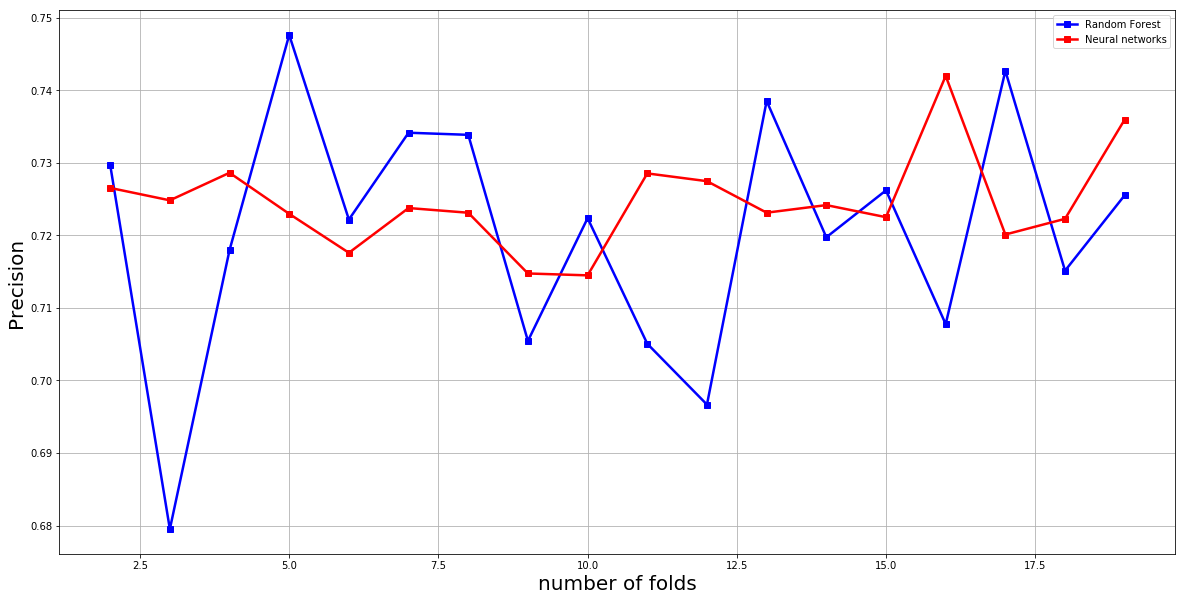

In [6]:
# Calculo da precision
folds_range = np.arange(2, 20)
colors = ['blue', 'red']
rf_precision_scores = []
mlp_precision_scores = []

# Definicao dos espacos de entrada e saida
X = np.array(diabetes.drop(diabetes.columns[-1], axis = 1))
Y = np.array(diabetes[diabetes.columns[-1]],dtype=str)

plt.figure(figsize=(20,10))
for k in folds_range:
    # Calculando precision do Random Forest
    rf = RandomForestClassifier(max_depth=2, random_state=0)
    rf_precision_scores.append(np.mean(cross_val_score(rf, X, Y, cv=k, scoring="precision_macro")))
    
    # Uso das redes neurais
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 4), random_state=1)
    mlp_precision_scores.append(np.mean(cross_val_score(mlp, X, Y, cv=k, scoring="precision_macro")))

plt.plot(folds_range, rf_precision_scores, marker='s', linestyle='-', color=colors[0], linewidth=2.5, label='Random Forest')
plt.plot(folds_range, mlp_precision_scores, marker='s', linestyle='-', color=colors[1], linewidth=2.5, label='Neural networks')
plt.xlabel("number of folds", fontsize=20)
plt.ylabel("Precision", fontsize=20)
plt.grid(True)
plt.legend()

Nota-se que a maior precisão ocorreu para Random Forest dividindo os dados em 5 partes.

Porém, também é perceptível que Random Forest apresenta uma oscilação na precisão muito maior que a de Redes Neurais, variando k de 1 a 18.

Temos que Random Forest oscila de aproximadamente 68% a 74.8%, equanto Redes Neurais oscila de aproximadamente 71% a 74%.

Deste modo, temos que Redes Neurais não sofre muito impacto na precisão quando se muda a quantidade de divisões dos dados. Sendo assim o modelo mais seguro a se apostar para novas observações não mapeadas.

## Utilizando Curva ROC e K-Fold estratificado

Aqui, iremos comparar os modelos de classificação Redes Neurais, Naive Bayes e Random Forest para checar tendências e se possível definir o que possui resultados superiores com método de k-fold estratificado.

In [8]:
# Calculo da curva ROC para 10-fold cross validation
colors = ['blue', 'red', 'green']
k=10

rf = RandomForestClassifier(max_depth=2, random_state=0)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 4), random_state=1)
naive_bayes = GaussianNB()

rf_auc = []
mlp_auc = []
nb_auc = []

folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for train_index, test_index in folds.split(X, Y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Aplicando os classificadores
    rf.fit(x_train, y_train)
    mlp.fit(x_train, y_train)
    naive_bayes.fit(x_train, y_train)
    
    # Calculando as probaibilidades
    y_predict_probabilities_rf = rf.predict_proba(x_test)[:,1] 
    y_predict_probabilities_mlp = mlp.predict_proba(x_test)[:,1] 
    y_predict_probabilities_nb = naive_bayes.predict_proba(x_test)[:,1] 
    
    # Armazenando taxas para aplicar a media ao final do process
    y_test = np.array(y_test, dtype='int')
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_probabilities_rf)
    rf_auc.append(auc(fpr, tpr))

    fpr, tpr, thresholds = roc_curve(y_test, y_predict_probabilities_mlp)
    mlp_auc.append(auc(fpr, tpr))    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_probabilities_nb)
    nb_auc.append(auc(fpr, tpr))

# Resultado Final
auc_results = pd.DataFrame(
    {
        "" : ['Random Forest', 'MLP (Neural Network)', 'Naive Bayes'],
        "Área sobre curva ROC" : [np.mean(np.array(rf_auc)), np.mean(np.array(mlp_auc)), np.mean(np.array(nb_auc))]
    }
)
auc_results

,,Área sobre curva ROC
0,Random Forest,0.772101
1,MLP (Neural Network),0.774083
2,Naive Bayes,0.815194


Utilizar a área abaixo da curva ROC é uma outra forma de se medir a ácurácia da classificação obtida.

Desta maneira, temos que Naive Bayes obteve um resultado superior para a ácurácia utilizando k-fold de 10 divisões estratificadas.


## Seleção de atributos: medição do F1 score para a seleção univariada

Aqui, iremos utilizar F1 Score para quantificar os resultados de quatro modelos distintos, acrescentando um atributo por vez, começando pelo mais importante, e assim sucessivamente.

Os modelos a serem comparados são Random Forest, Redes Neurais, Naive Bayes e KNN.

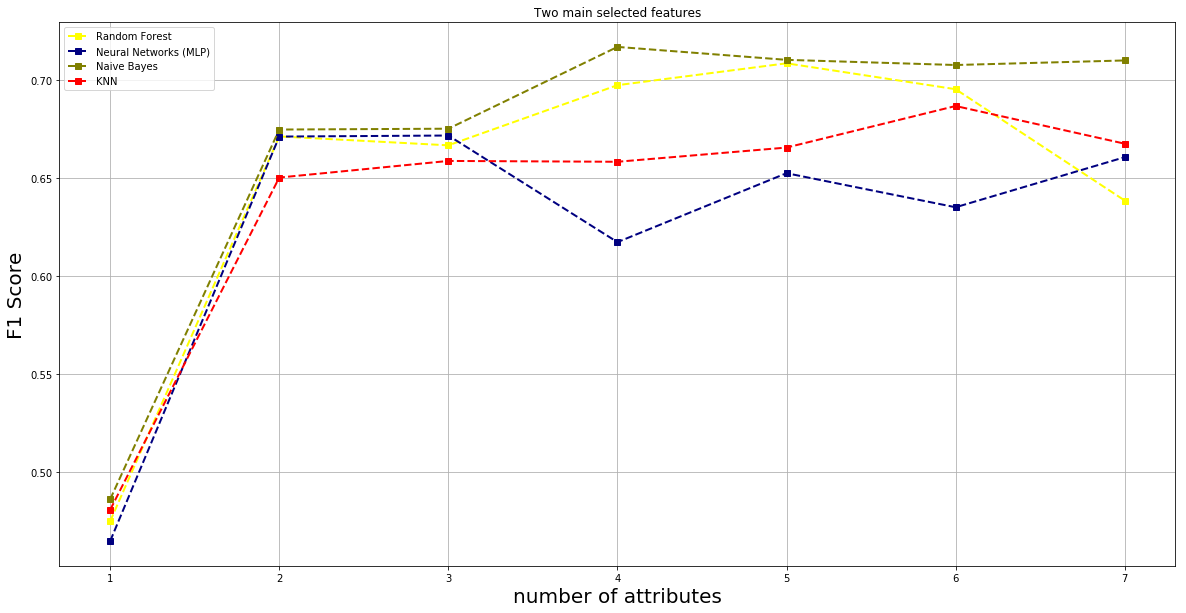

In [9]:
# Selecao univariada dos atributos
k=10
features_range = np.arange(1,8)
colors = ['yellow', 'navy', 'olive', 'red']

random_forest = RandomForestClassifier(max_depth=2, random_state=0)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50), random_state=1)
knn = KNeighborsClassifier(n_neighbors=3)
naive_bayes = GaussianNB()

rf_f1_scores = []
mlp_f1_scores = []
nb_f1_scores = []
knn_f1_scores = []

for nfeatures in features_range:
    test = SelectKBest(score_func=chi2, k=nfeatures)
    fit = test.fit(X, Y)
    features = fit.transform(X)
    XS = features
    
    # calculando f1_score para cada classificador
    rf_f1_scores.append(np.mean(cross_val_score(random_forest, XS, Y, cv=k, scoring="f1_macro")))
    mlp_f1_scores.append(np.mean(cross_val_score(mlp, XS, Y, cv=k, scoring="f1_macro")))
    nb_f1_scores.append(np.mean(cross_val_score(naive_bayes, XS, Y, cv=k, scoring="f1_macro")))
    knn_f1_scores.append(np.mean(cross_val_score(knn, XS, Y, cv=k, scoring="f1_macro")))


# Criando grafico da relacao entre f1 scores e atributos selecionados
plt.figure(figsize=(20,10))
plt.plot(features_range, rf_f1_scores, marker='s', linestyle='--', color=colors[0], linewidth=2, label='Random Forest')
plt.plot(features_range, mlp_f1_scores, marker='s', linestyle='--', color=colors[1], linewidth=2, label='Neural Networks (MLP)')
plt.plot(features_range, nb_f1_scores, marker='s', linestyle='--', color=colors[2], linewidth=2, label='Naive Bayes')
plt.plot(features_range, knn_f1_scores, marker='s', linestyle='--', color=colors[3], linewidth=2, label='KNN')
plt.legend()
plt.xlabel("number of attributes", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
plt.title('Two main selected features')
plt.grid(True)
plt.show(True)


Temos que o maior aumento incremental de F1 se dá quando utilizamos 2 atributos ao invés de apenas 1, aumentando em mais de 10% para todos os 4 modelos. 

Dentre os 4 modelos, Naive Bayes foi o que apresentou melhores resultados, independente da quantidade de atributos escolhidos.

E para Naive Bayes, o gráfico evidencia que podemos utilizar apenas 2 atributos, ou talvez no máximo 4. Não é inteligente utilizar mais do que 4 atributos, pois além de precisar de mais informação, não fornece melhores resultados.

## Análise de Componentes principais

Este método é utilizado quando desejamos concentrar a maior parte da informação possível (variância explicada) para a menor quantidade de componentes possível.

Normalmente para-se em 2 atributos, pois desta maneira é fácil de interpretar visualmente por meio de um biplot como as duas componentes se relacionam com as observações.

/home/ricardoffv/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ricardoffv/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ricardoffv/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ricardoffv/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ricardoffv/.local/

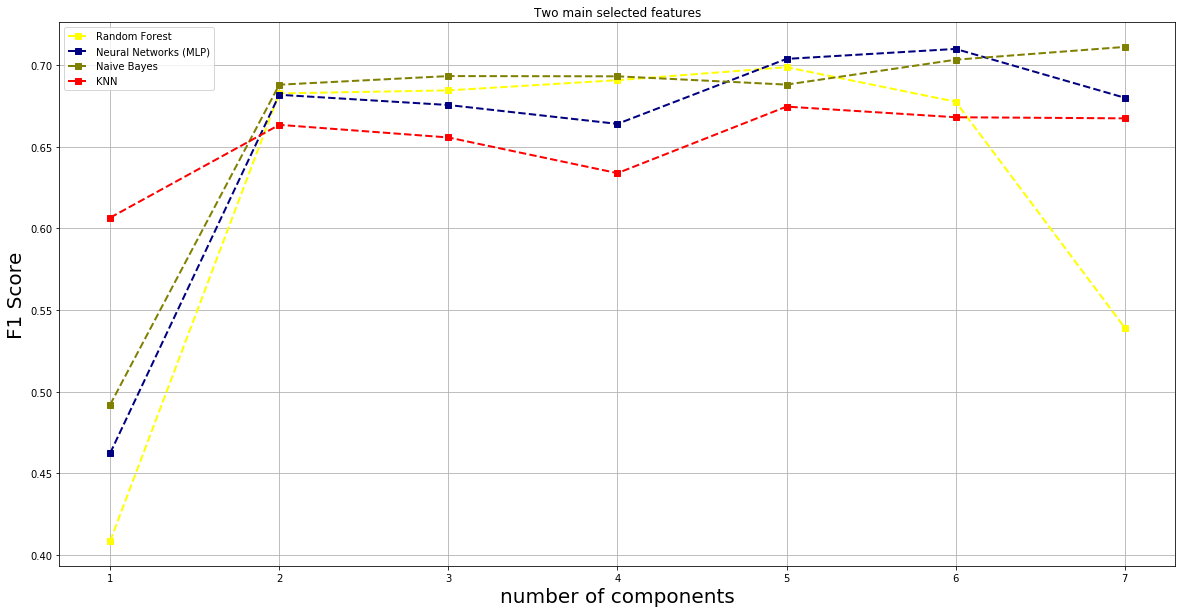

In [11]:
# Analise dos componentes principais para verificar F1 Score
k=10
features_range = np.arange(1,8)
colors = ['yellow', 'navy', 'olive', 'red']

random_forest = RandomForestClassifier(max_depth=2, random_state=0)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50), random_state=1)
knn = KNeighborsClassifier(n_neighbors=3)
naive_bayes = GaussianNB()

rf_f1_scores = []
mlp_f1_scores = []
nb_f1_scores = []
knn_f1_scores = []

for nfeatures in features_range:
    pca = PCA(n_components=nfeatures)
    pca_result = pca.fit_transform(X)
    XS = pca_result
    
    # calculando f1_score para cada classificador
    rf_f1_scores.append(np.mean(cross_val_score(random_forest, XS, Y, cv=k, scoring="f1_macro")))
    mlp_f1_scores.append(np.mean(cross_val_score(mlp, XS, Y, cv=k, scoring="f1_macro")))
    nb_f1_scores.append(np.mean(cross_val_score(naive_bayes, XS, Y, cv=k, scoring="f1_macro")))
    knn_f1_scores.append(np.mean(cross_val_score(knn, XS, Y, cv=k, scoring="f1_macro")))


# Criando grafico da relacao entre f1 scores e atributos selecionados
plt.figure(figsize=(20,10))
plt.plot(features_range, rf_f1_scores, marker='s', linestyle='--', color=colors[0], linewidth=2, label='Random Forest')
plt.plot(features_range, mlp_f1_scores, marker='s', linestyle='--', color=colors[1], linewidth=2, label='Neural Networks (MLP)')
plt.plot(features_range, nb_f1_scores, marker='s', linestyle='--', color=colors[2], linewidth=2, label='Naive Bayes')
plt.plot(features_range, knn_f1_scores, marker='s', linestyle='--', color=colors[3], linewidth=2, label='KNN')
plt.legend()
plt.xlabel("number of components", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
plt.grid(True)
plt.show(True)

Utilizando a análise de componentes principais, percebe-se que não há mais uma hegemonia para Naive Bayes independente da quantidade de atributos. Temos que para 5 componentes principais ao melhor modelo é o de Redes Neurais.

Todavia, nem sempre o melhor é utilizar o maior número possível de componentes. Neste caso, iremos decidir baseado no F1 Score e também na variância explicada em decorrência da quantidade de componentes utilizados.

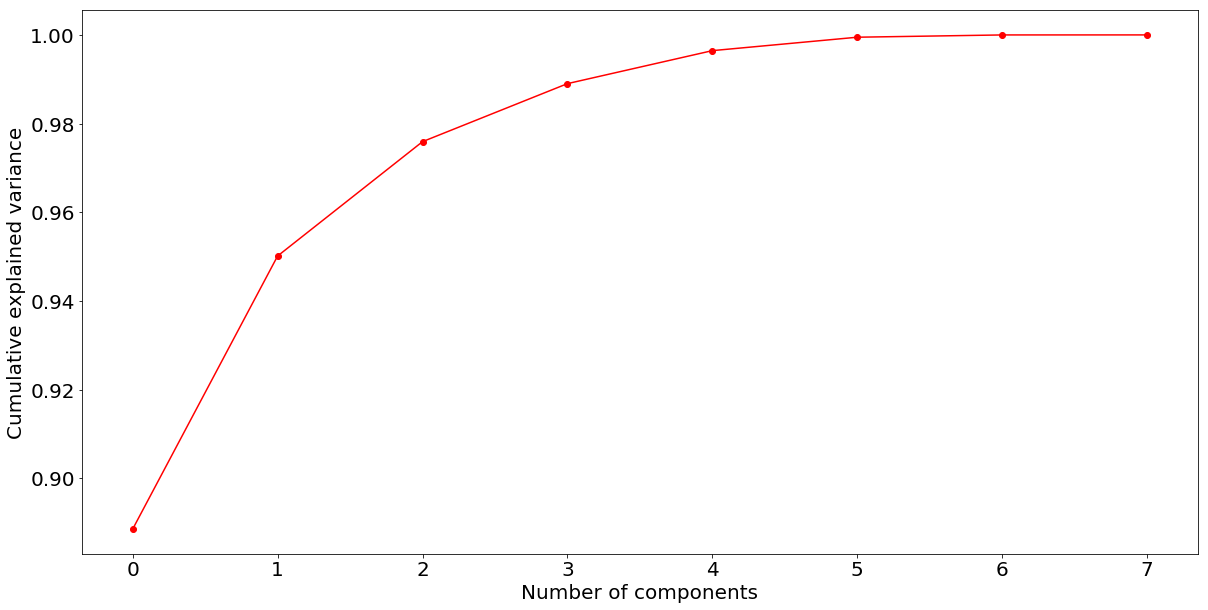

In [12]:
pca = PCA().fit(X)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Cumulative explained variance', fontsize=20);
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show(True)

Temos que o maior ganho incremental de variância explicada se dá para 2 componentes principais, totalizando 95% de variância explicada.

Normalmente, poderíamos parar por aqui.

Porém como nosso intuito é maximizar o poder de classificação na modelagem, temos que o ponto ótimo seria para 5 componentes principais, totalizando quase 100% de variância explicada, o que implica que aumentar mais componentes é quase inútil para aumentar a informação sobre os dados.

E deste modo, temos que o melhor modelo a ser utilizado seria o de Redes Neurais com 5 componentes principais. Proporcionando F1 Score de aproximadamente 70%.


## Trabalhando com dados do Kaggle - Titanic

Nesta parte final do projeto, será explorada a base de dados do Titanic, em que a classe de uma observação determina, a partir de um conjunto de atributos, se uma pessoa sobreviveu ou não ao naufrágio do navio.

A partir deste dataset, serão analisados:
- A	curva ROC a partir dos classificadores de Redes Neurais (MLP) e Random Forest;
- Seleção dos atributos mais importantes através do método Wrapper;
- Gráfico da precisão em função	do número de atributos usados

In [85]:
# Leitura da base de dados
titanic = pd.read_csv('./titanic-train.csv', header=(0))
titanic = titanic.replace('', np.nan)
titanic = titanic.dropna()
print(titanic.shape)
titanic.head(10)

(183, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C


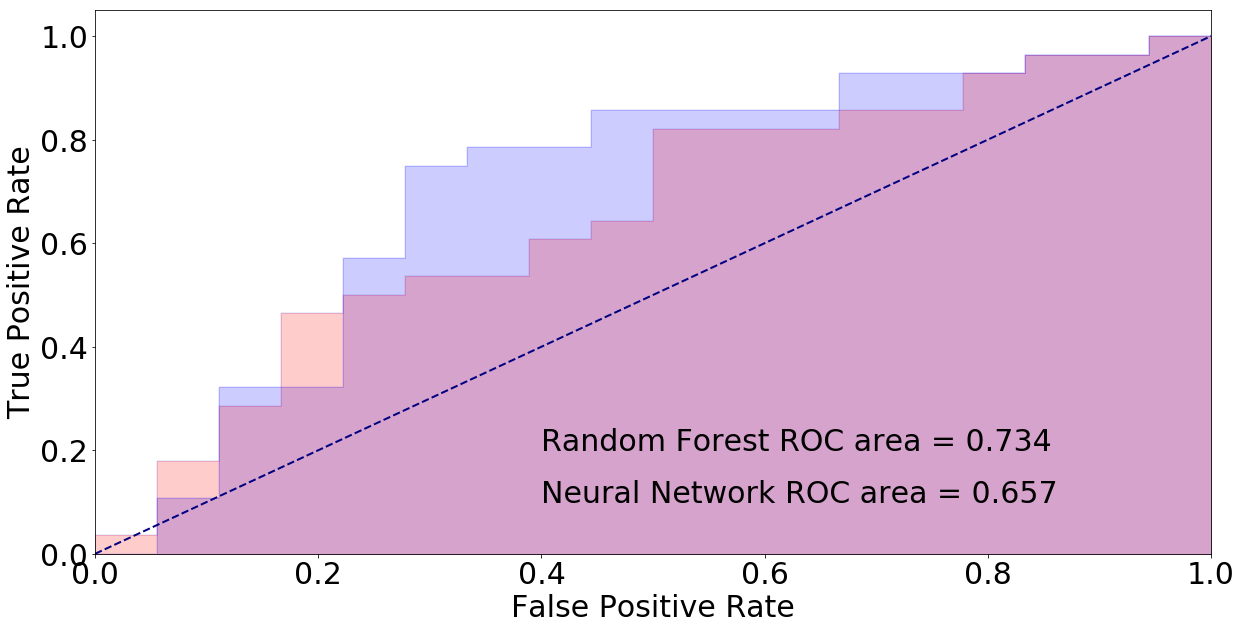

In [101]:
# Curva ROC para MLP e Random Forest (utilizando holdouts)
p=0.75
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50), random_state=1)

# Definicao dos conjuntos
X = np.array(titanic.drop(['Name', 'Sex', 'Survived', 'PassengerId', 'Ticket', 'Cabin', 'Embarked'], axis = 1))
Y = np.array(titanic[titanic.columns[1]],dtype=str)

rf_auc = []
mlp_auc = []

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 1-p, random_state = 42)

# Aplicando os classificadores
rf.fit(x_train, y_train)
mlp.fit(x_train, y_train)

# Calculando as probaibilidades
y_predict_probabilities_rf = rf.predict_proba(x_test)[:,1] 
y_predict_probabilities_mlp = mlp.predict_proba(x_test)[:,1] 

# Calculando a curva roc
y_test = np.array(y_test, dtype='int')
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_predict_probabilities_rf)
rf_roc_auc = auc(rf_fpr, rf_tpr)

mlp_fpr, mlp_tpr, thresholds = roc_curve(y_test, y_predict_probabilities_mlp)
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)

# Exibicao da curva ROC
plt.figure(figsize=(20,10))
plt.step(rf_fpr, rf_tpr, color='b', alpha=0.1, where='post')
plt.fill_between(rf_fpr, rf_tpr, step='post', alpha=0.2, color='b')
plt.step(mlp_fpr, mlp_tpr, color='b', alpha=0.1, where='post')
plt.fill_between(mlp_fpr, mlp_tpr, step='post', alpha=0.2, color='r')

plt.text(0.4, 0.2, 'Random Forest ROC area = %0.3f' % rf_roc_auc, fontsize = 30)
plt.text(0.4, 0.1, 'Neural Network ROC area = %0.3f' % mlp_roc_auc, fontsize = 30)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate', fontsize = 30)
plt.xticks(color='k', size=30)
plt.yticks(color='k', size=30)
plt.show()

In [105]:
# Selecao dos atributos mais importantes atraves do metodo wrapper
rf = RandomForestClassifier(max_depth=2, random_state=0)

features_range = np.arange(1,6)
list_labels = list(titanic.drop(['Name', 'Survived', 'Sex', 'PassengerId', 'Ticket', 'Cabin', 'Embarked'], axis = 1))

print('Ranking de atributos mais importantes')
for nfeatures in features_range:
    rfe = RFE(rf, nfeatures)
    fit = rfe.fit(X, Y)
    print('Atributos selecionáveis: ',fit.n_features_)
    print('\nAtributos Selecionados: ')
    f_selected = []
    for f in np.arange(0, len(fit.support_)):
        if(fit.support_[f] == True):
            print(list_labels[f])
            f_selected.append(list_labels[f])
    print('\nFeature ranking:')
    for i in np.arange(0, len(fit.ranking_)):
        print(fit.ranking_[i],':', list_labels[i])
    print('\n\n')

Ranking de atributos mais importantes
Atributos selecionáveis:  1

Atributos Selecionados: 
Fare

Feature ranking:
4 : Pclass
2 : Age
3 : SibSp
5 : Parch
1 : Fare



Atributos selecionáveis:  2

Atributos Selecionados: 
Age
Fare

Feature ranking:
3 : Pclass
1 : Age
2 : SibSp
4 : Parch
1 : Fare



Atributos selecionáveis:  3

Atributos Selecionados: 
Age
SibSp
Fare

Feature ranking:
2 : Pclass
1 : Age
1 : SibSp
3 : Parch
1 : Fare



Atributos selecionáveis:  4

Atributos Selecionados: 
Pclass
Age
SibSp
Fare

Feature ranking:
1 : Pclass
1 : Age
1 : SibSp
2 : Parch
1 : Fare



Atributos selecionáveis:  5

Atributos Selecionados: 
Pclass
Age
SibSp
Parch
Fare

Feature ranking:
1 : Pclass
1 : Age
1 : SibSp
1 : Parch
1 : Fare





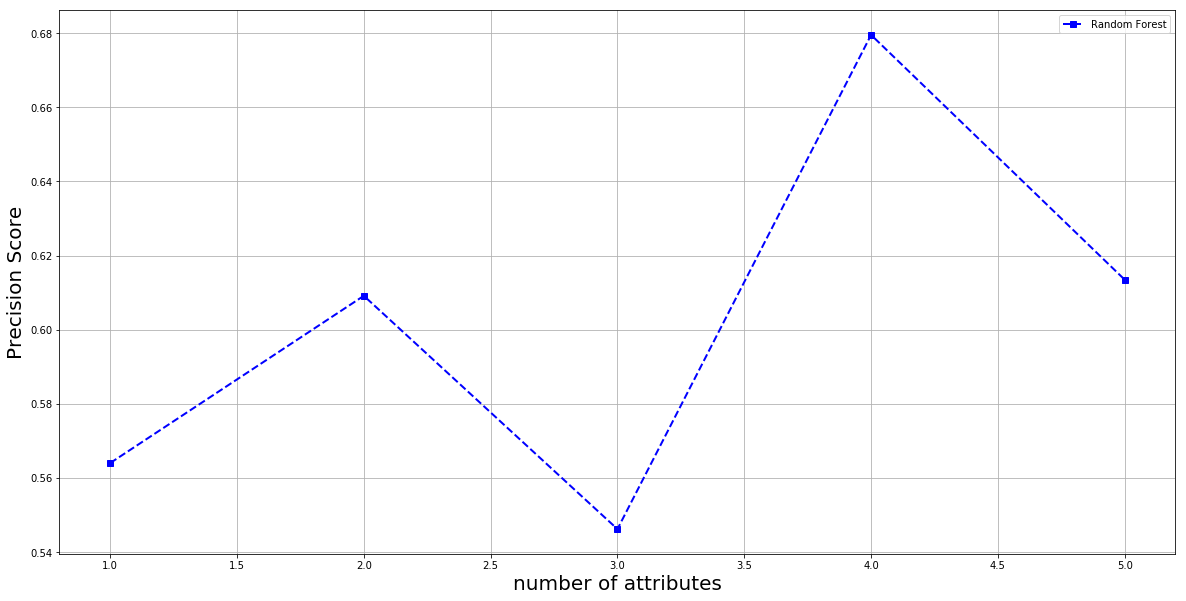

In [114]:
# Gráfico da precisão em função do número de atributos usados
k=10
features_range = np.arange(1,6)

rf = RandomForestClassifier(max_depth=2, random_state=0)

rf_precision_scores = []

for nfeatures in features_range:
    # calculando precision para classificador
    # Random Forest
    rfe = RFE(rf, nfeatures)
    fit = rfe.fit(X, Y)
    features = fit.transform(X)
    XS = features    
    rf_precision_scores.append(np.mean(cross_val_score(random_forest, XS, Y, cv=k, scoring="precision_macro")))


# Criando grafico da relacao entre f1 scores e atributos selecionados
plt.figure(figsize=(20,10))
plt.plot(features_range, rf_precision_scores, marker='s', linestyle='--', color='b', linewidth=2, label='Random Forest')
plt.legend()
plt.xlabel("number of attributes", fontsize=20)
plt.ylabel("Precision Score", fontsize=20)
plt.grid(True)
plt.show(True)


Algumas observações sobre as extrações das medidas devem ser feitas: muitas unidades experimentais foram excluídas dos cáclulos por possuírem algum dado faltante; apenas 5 atributos restaram do dataset por serem numéricos para que as análises de curva ROC e seleção de atributos pelo método Wrapper fossem realizados com sucesso; apenas o classificador Random Forest permitiu a geração dos dados de análise do método de seleção Wrapper, os algoritmos de classificação das redes neurais, do Naive Bayes e do KNN não conseguiram suportar o espaço de entrada transformado por não possuírem métodos built-in implementados para tratar a nova entrada.

Perante os dados obtidos foi possível observar que as curvas de aprendizado tanto do Random Forest quanto da rede neural, possuem um comportamento parecido, sendo que a rede neural depende fortemente da quantidade de neurônios nas camadas escondidas, o que pode descrescer ainda mais a taxa de aprendizado.

Quanto à seleção de atributos do método Wrapper com o classificador Random Forest, pode-se perceber que "Fare" é o atributo mais importante e a maior taxa de precisão, mesmo não sendo maior que 0.7, pode ser obtida tendo apenas 4 atributos numéricos.

Uma análise mais aprofundada poderia gerar precisões melhores, sendo por uma conversão básica de alguns atributos do dataset como Embarked e Cabin, que, ponderados, poderiam exercer mais influência em uma classificação correta. Porém, neste projeto, tomou-se uma abordagem mais simplista, tanto para a decisão de apenas utilizar atributos numéricos para a seleção e para a classificação, quanto para a decisão de desconsiderar unidades experimentais com dados faltantes, ao invés de preenchê-los com valores calculados.